In [12]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn as nn
from torch.utils.data import DataLoader, TensorDataset
from mamba import S4,S4Regressor

In [16]:
BATCH_SIZE = 16
seq_len = 32
hidden_dim = 64
N_SAMPLES = 512

torch.manual_seed(0)
X = torch.randn(N_SAMPLES, seq_len, hidden_dim)
Y = (X[:, :, 0] + 0.5 * torch.roll(X[:, :, 1], shifts=1, dims=1)).unsqueeze(-1)

dataset = TensorDataset(X, Y)
loader = DataLoader(dataset, batch_size=16, shuffle=True)

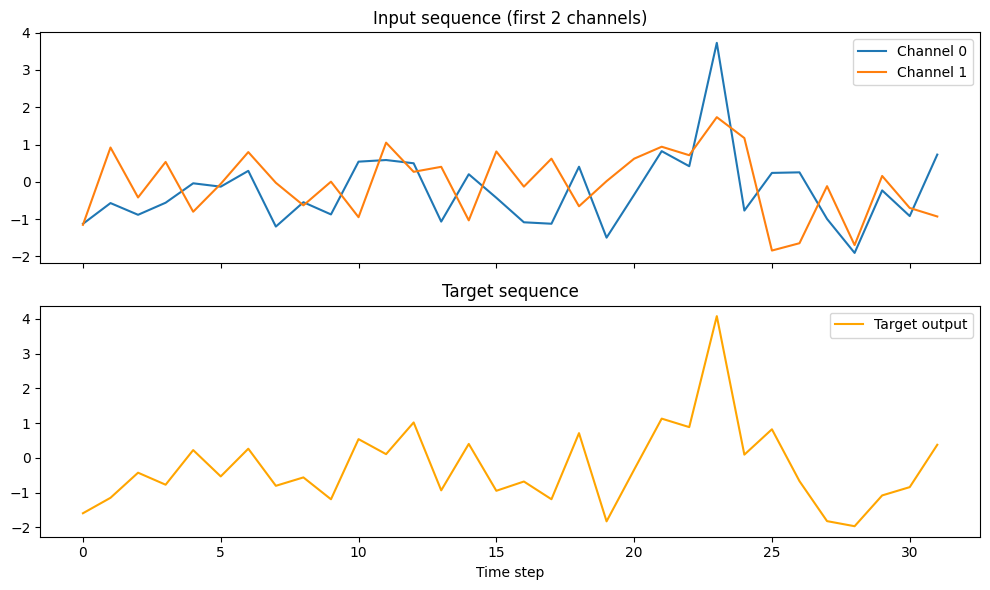

In [17]:
sample_x, sample_y = dataset[0]
fig, ax = plt.subplots(2, 1, figsize=(10, 6), sharex=True)

# Plot first few channels of input
ax[0].plot(sample_x[:, 0].numpy(), label="Channel 0")
ax[0].plot(sample_x[:, 1].numpy(), label="Channel 1")
ax[0].set_title("Input sequence (first 2 channels)")
ax[0].legend()

# Plot target
ax[1].plot(sample_y.squeeze().numpy(), color='orange', label="Target output")
ax[1].set_title("Target sequence")
ax[1].legend()

plt.xlabel("Time step")
plt.tight_layout()
plt.show()

In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = S4Regressor(channels=seq_len, hidden_dim=hidden_dim).to(device)
opt = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)

EPOCHS = 5
for epoch in range(EPOCHS):
    model.train()
    total_loss = 0.0
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)

        # Forward pass
        pred = model(xb)
        loss = nn.functional.mse_loss(pred, yb)

        # Backward + update
        opt.zero_grad()
        loss.backward()
        opt.step()

        total_loss += loss.item() * xb.size(0)

    avg_loss = total_loss / len(dataset)
    print(f"Epoch {epoch+1}/{EPOCHS} - Loss: {avg_loss:.6f}")

# -------------------------
# 5. Inference example
# -------------------------
model.eval()
test_in = torch.randn(1, seq_len, hidden_dim).to(device)
with torch.no_grad():
    test_out = model(test_in)
print("Test output shape:", test_out.shape)

TypeError: arange() received an invalid combination of arguments - got (int, dtype=type, device=builtin_function_or_method), but expected one of:
 * (Number end, *, Tensor out = None, torch.dtype dtype = None, torch.layout layout = None, torch.device device = None, bool pin_memory = False, bool requires_grad = False)
 * (Number start, Number end, *, torch.dtype dtype = None, torch.layout layout = None, torch.device device = None, bool pin_memory = False, bool requires_grad = False)
 * (Number start, Number end, Number step = 1, *, Tensor out = None, torch.dtype dtype = None, torch.layout layout = None, torch.device device = None, bool pin_memory = False, bool requires_grad = False)
